<a href="https://colab.research.google.com/github/kitewatermelon/MAI-Lab/blob/main/(final)cerebellar_atrophy_data_outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import FuncFormatter

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#이론

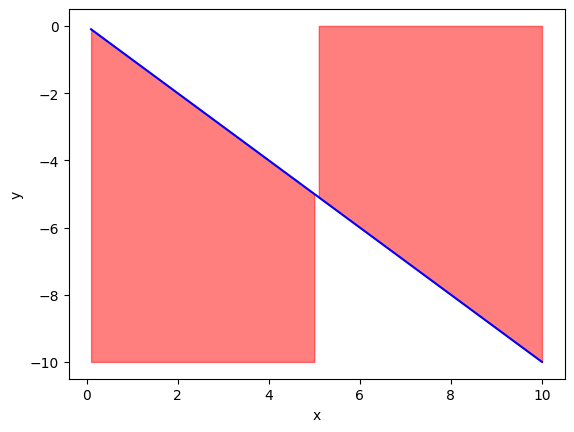

- 빨간 부위에 데이터가 많이 있으면 음의 상관관계를 띄는데 방해가 됨

```
for i in range(적당한 숫자):   
  -  1. 주어진 데이터에 대한 모델을 학습하고 기울기를 저장한다.
  -  2. 빨간 부위에 속해 있는 데이터들과 선의 거리를 구한 후 절대값을 씌운다.
  -  3. 가장 멀리 있는 데이터를 지운 후 데이터를 저장한다.
  
4. 기울기를 확인하여 엘보우 기법을 이용하여 적절한 아웃라이어의 수를 구한다.
```



데이터 로드

In [2]:
file = '/content/drive/MyDrive/Lab/cerebellar_atrophy_data.csv'

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Lab/cerebellar_atrophy_data.csv',encoding='CP949')

성 one-hot-encoding

In [4]:
data['sex'] = data['sex'].str.replace("'", "").astype(int)

필요 없는 정보인 name drop

In [5]:
data = data.drop('name', axis=1)

앞으로 저장해야 할 리스트 선언

In [6]:
#회귀 선
original_line = []

#회귀 선 기울기
original_coef = []

#=====plt 그리기 용=====
data_set = []
outlier_set = []
coef_difference = []

### makeModel(df)
- 모델 생성 학습 후 생성된 선형 모델 저장
- 기울기 저장
- threshold 반환   
  - threshold는 회귀선을 기준으로 위/아래로 나눔

In [7]:
def makeModel(df):

  df = pd.DataFrame(df)

  # 선형 회귀 모델 생성
  model = LinearRegression()

  # 모델 학습
  model.fit(df[['icars']], df['cerebellum_volume'])

  # 선형 회귀식의 계수와 절편 출력
  slope = model.coef_
  intercept = model.intercept_

  # 임계값 설정하여 데이터 분할
  threshold = slope * df['icars'] + intercept
  df_above = df[df['cerebellum_volume'] > threshold]
  df_below = df[df['cerebellum_volume'] < threshold]

  #회귀선 저장
  original_line.append(model.predict(df[['icars']]))

  #기울기 저장
  original_coef.append(model.coef_)
  #
  return threshold

### initModel(df, original_line)
- df에 pred(예측값), difference(실제값 - 예측값) column 생성

In [8]:
#모델 초기화
def initModel(df, original_line):
  for i in range(len(original_line)):
    df['pred'] = original_line
    df['difference'] = df['cerebellum_volume'] - df['pred']


### seperateData(df, threshold)
- sa, ba, sa_icars_mean, ba_icars_mean 반환
  - sa: upper part of data which seperated by threshold
  - ba: lower part of data which seperated by threshold
  - sa_icars_mean: mean of sa's column 'icars'
  - ba_icars_mean: mean of ba's column 'icars'



In [9]:
def seperateData(df, threshold):
  sa = df[df['cerebellum_volume'] > threshold]
  ba = df[df['cerebellum_volume'] < threshold]

  sa_icars_mean = np.mean(sa['icars'])
  ba_icars_mean = np.mean(ba['icars'])

  return sa, ba, sa_icars_mean, ba_icars_mean

### makeOutlier(sa, ba, sa_icars_mean, ba_icars_mean, df)
- above_outlier: sa에서 mean 값보다 큰값 중 difference가 가장 큰 값
- below_outlier: ba에서 mean 값보다 큰값 중 difference가 가장 작은 값
- outlier: above_outlier와 below_outlier 중 절대값이 더 큰 값


In [10]:
def makeOutlier(sa, ba, sa_icars_mean, ba_icars_mean, df):
  above_outlier = df.iloc[sa[sa['icars'] > sa_icars_mean]['difference'].idxmax()]
  below_outlier = df.iloc[ba[ba['icars'] < ba_icars_mean]['difference'].idxmin()]
  if above_outlier['difference'] >= abs(below_outlier['difference']):
    outlier = above_outlier
  else:
    outlier = below_outlier
  return outlier

### drawOutlierModel(outlier, original_line, df)
- 회귀선, 데이터, 아웃라이어를 가시화

In [11]:
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}k'

def drawOutlierModel(outlier, original_line, df):
  plt.figure(figsize=(10, 5))

  plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

  # 예측된 값이 임계값 이상인 경우 파랑색으로 표시
  plt.scatter(df['icars'], df['cerebellum_volume'], color='black', label='all df')
  plt.scatter(sa[sa['icars'] > sa_icars_mean]['icars'], sa[sa['icars'] > sa_icars_mean]['cerebellum_volume'], color='orange', label='risk group')
  plt.scatter(ba[ba['icars'] < ba_icars_mean]['icars'], ba[ba['icars'] < ba_icars_mean]['cerebellum_volume'], color='orange', label='risk group')

  plt.scatter(outlier['icars'], outlier['cerebellum_volume'], color='red', label='outlier')

  plt.plot(df['icars'], original_line , linestyle='-', color='blue')

  # 그래프에 축 레이블 추가
  plt.xlabel('icars')
  plt.ylabel('cerebellum_volume')

  # 범례 추가
  plt.legend()

  # 그래프 보여주기
  plt.show()

### deleteOutlier(df, outlier)
- 아웃라이어를 삭제하고 인덱스를 초기화

In [12]:
def deleteOutlier(df, outlier):
  df = df.drop(df[df['cerebellum_volume'] == outlier['cerebellum_volume']].index)
  df = df.reset_index(drop=True)
  return df

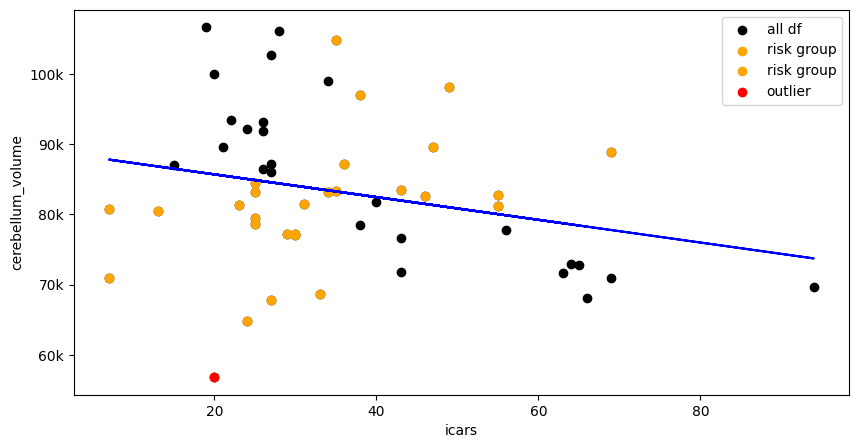

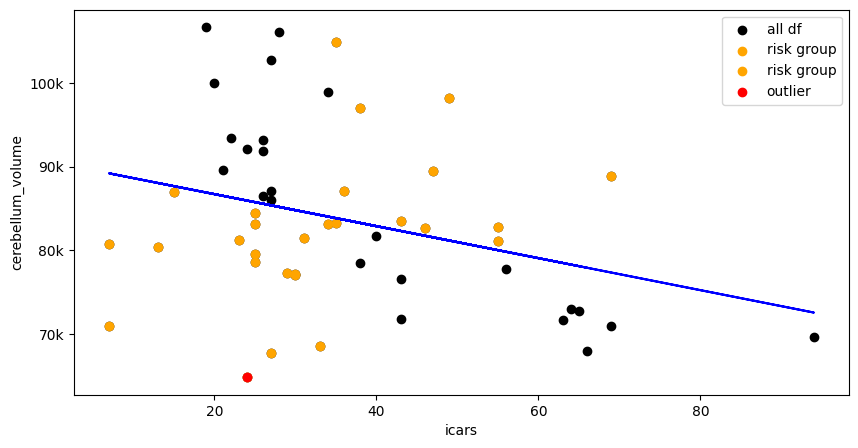

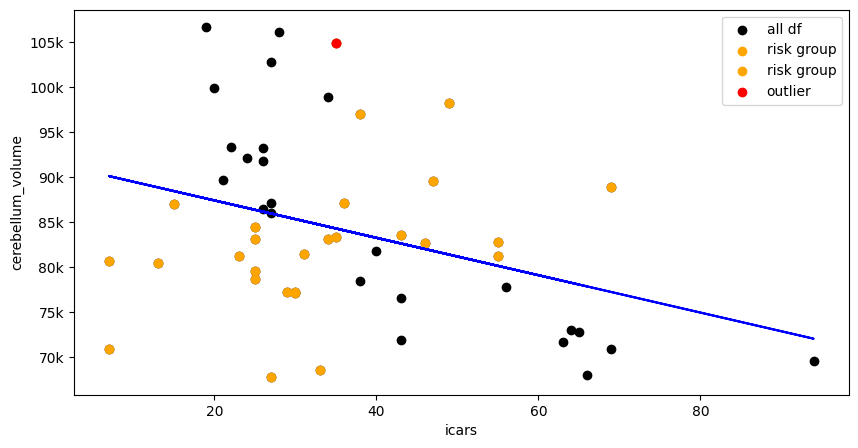

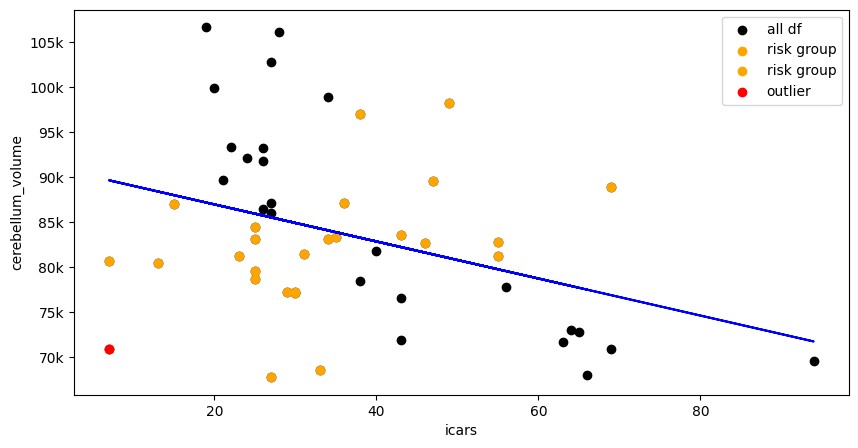

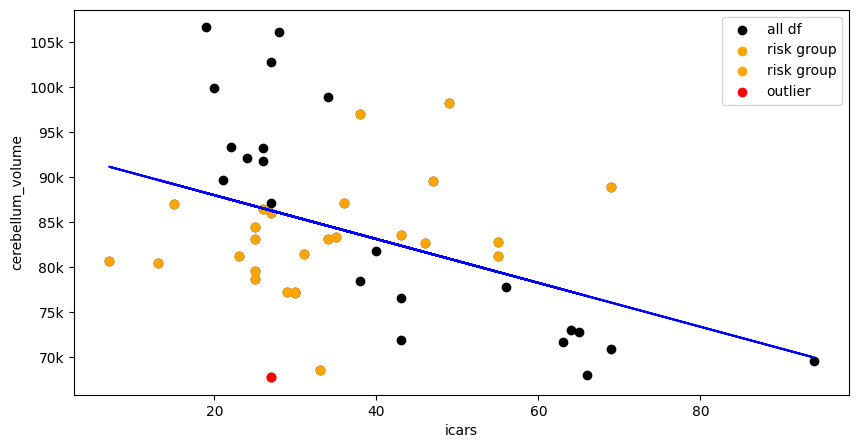

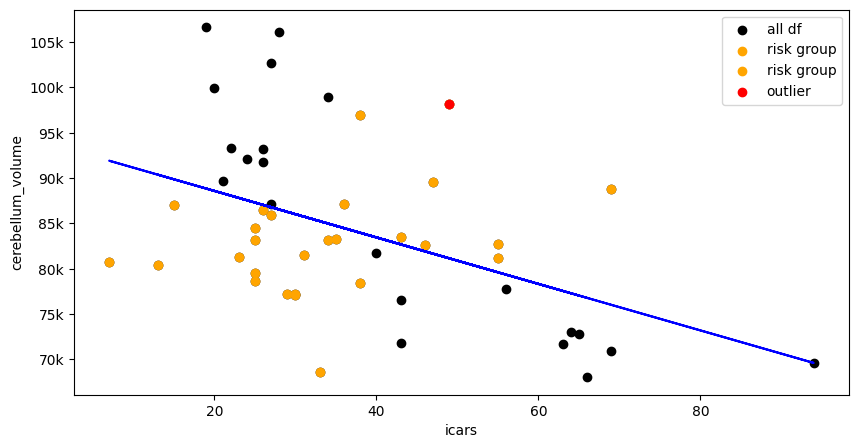

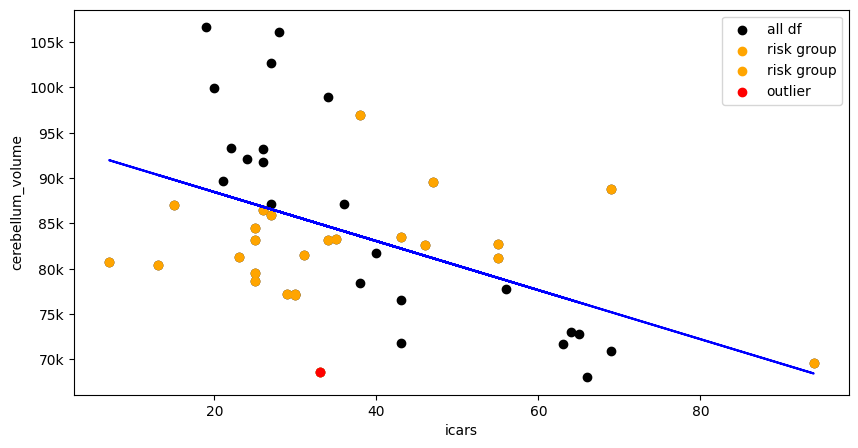

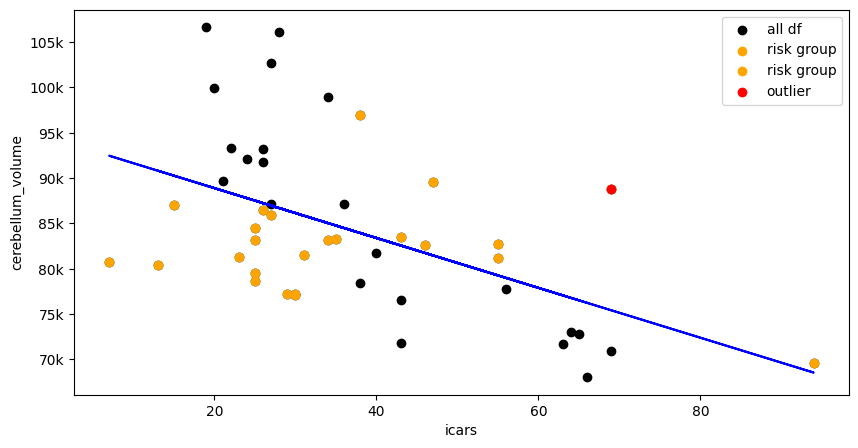

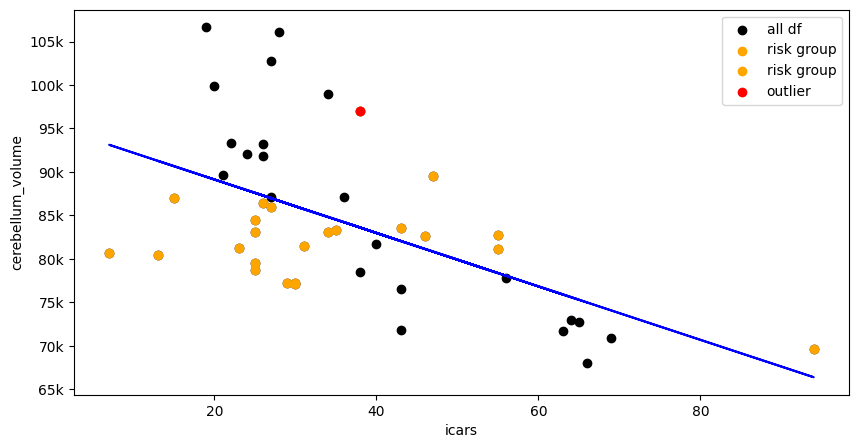

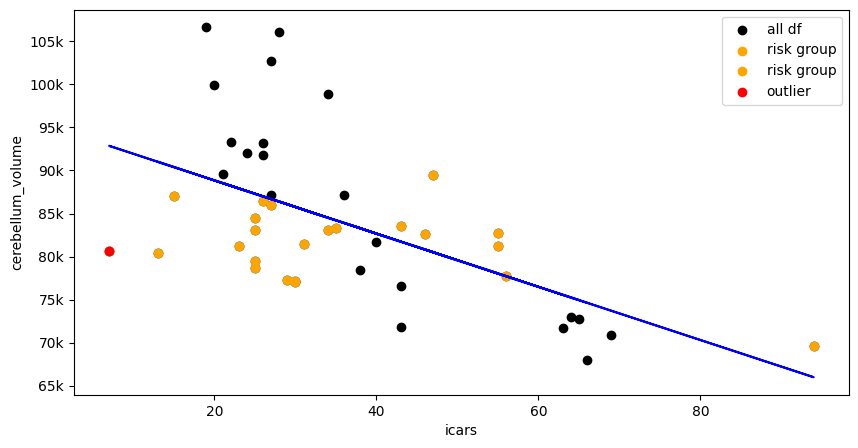

In [13]:
df = data
iter_num = 10
for i in range(iter_num):
  data_set.append(df)
  threshold = makeModel(df)
  initModel(df, original_line[i])
  sa, ba, sa_icars_mean, ba_icars_mean = seperateData(df, threshold)
  outlier = makeOutlier(sa, ba, sa_icars_mean, ba_icars_mean, df)
  outlier_set.append(outlier)
  drawOutlierModel(outlier, original_line[i], df)
  df = deleteOutlier(df, outlier)

In [14]:
original_coef

[array([-161.70919587]),
 array([-191.04019083]),
 array([-207.62373931]),
 array([-205.79114246]),
 array([-243.58912224]),
 array([-256.40372331]),
 array([-270.45194828]),
 array([-274.98215403]),
 array([-307.32501968]),
 array([-309.01159247])]

### 회귀선 히스토리

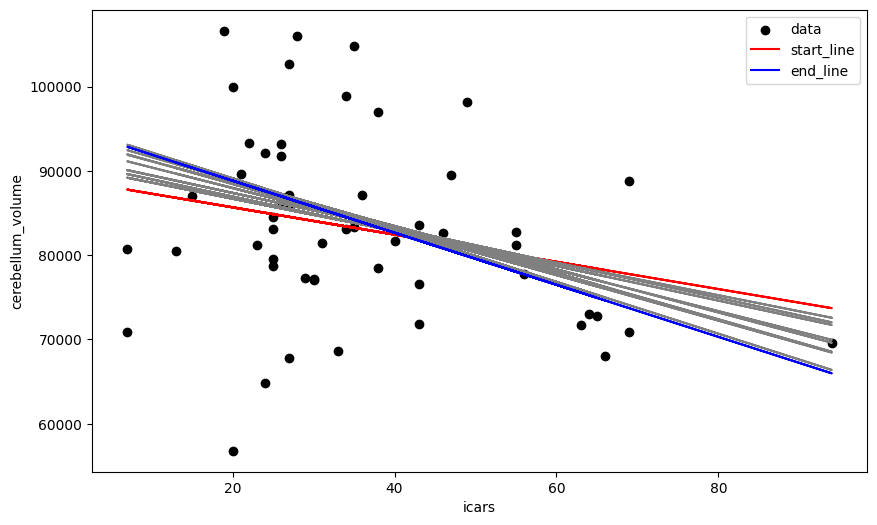

In [15]:
plt.figure(figsize=(10, 6))

# 예측된 값이 임계값 이상인 경우 파랑색으로 표시
plt.scatter(data['icars'], data['cerebellum_volume'], color='black', label='data')

# 선형 회귀 예측 결과 그리기 (초록색)
for i in range(len(original_line)):
  if i == 0:
    plt.plot(data_set[i]['icars'], original_line[i] , linestyle='-', color='red', label='start_line')
  elif i == iter_num-1:
    plt.plot(data_set[i]['icars'], original_line[i] , linestyle='-', color='blue', label='end_line')
  else:
    plt.plot(data_set[i]['icars'], original_line[i] , linestyle='-', color='gray')

# 그래프에 축 레이블 추가
plt.xlabel('icars')
plt.ylabel('cerebellum_volume')

# 범례 추가
plt.legend()

# 그래프 보여주기
plt.show()

In [16]:
for i in range(iter_num-1):
  coef_difference.append(float(original_coef[i]-original_coef[i+1]))

max_difference = max(coef_difference)
max_index = coef_difference.index(max_difference)
print(max_index)

3


### 기울기와 기울기간 차이 그래프

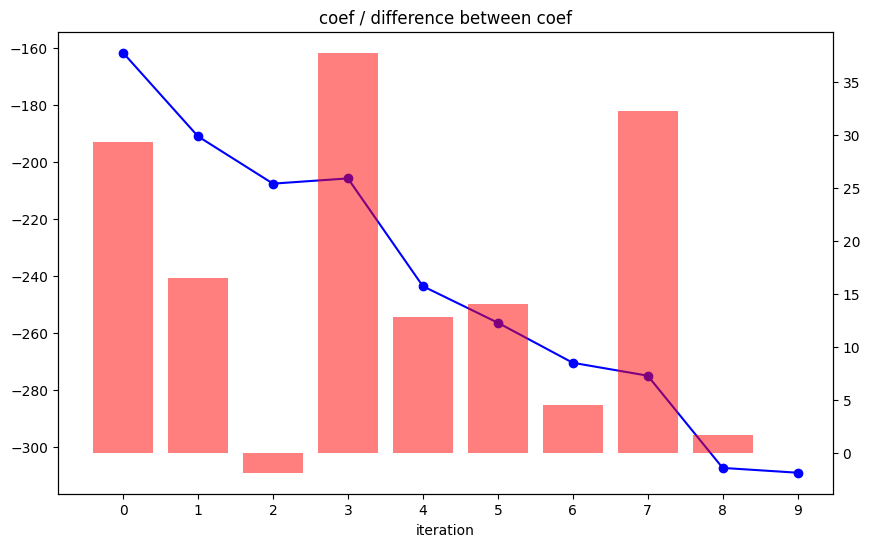

In [17]:
# 새로운 그림(figure) 생성
plt.figure(figsize=(10, 6))

# 첫 번째 y축 (선형 회귀 예측 결과, 초록색)
plt.plot(range(iter_num), original_coef, marker='o', linestyle='-', color='blue')
plt.xlabel('iteration')
plt.xticks(range(iter_num))

# 두 번째 y축 (바 그래프, 빨간색)
ax2 = plt.twinx()
ax2.bar(range(iter_num - 1), coef_difference, color='red', alpha=0.5)

# 그래프 보여주기
plt.title('coef / difference between coef')
plt.show()

### 최종 아웃라이어 분포

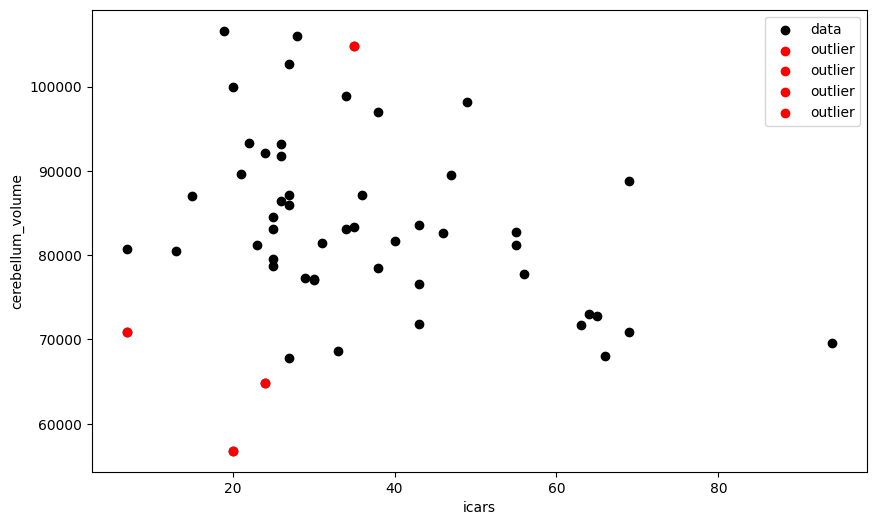

In [18]:
plt.figure(figsize=(10, 6))

# 예측된 값이 임계값 이상인 경우 파랑색으로 표시
plt.scatter(data['icars'], data['cerebellum_volume'], color='black', label='data')
for i in range(max_index+1):
  plt.scatter(outlier_set[i]['icars'], outlier_set[i]['cerebellum_volume'], color='red', label='outlier')

plt.xlabel('icars')
plt.ylabel('cerebellum_volume')

plt.legend()

plt.show()